# Visualization of calculated theoretical spectra from GROMACS

First of all, we need to import the relevant libraries for the visualization:

In [1]:
import numpy as np
import re
import subprocess as sp
import math
import matplotlib.pyplot as plt

## Read data from GROMACS files

We need to read all the required GROMACS files to calculate the intensities. We need the following files:
* Molecular charges (topol.top)
* Eigenvectors (eigenvec.trr)
* Eigenfrequencies (eigenfreq.xvg)

In [2]:
molecule_of_interest = "quinoline" # <--- feel free to change to other examples in the GitHub repository
path = "../examples/GAFF-ESP/" + molecule_of_interest + "/"

# eigenfrequencies
eigenfrequencies = []
eigenfrequencies_file = open(path + "eigenfreq.xvg", "r")
for line in eigenfrequencies_file:
    if line[0] != "@" and line[0] != "#":
        split_line = re.split(" +",line.strip())
        eigenfrequencies.append(float(split_line[1]))

# eigenvectors
eigenvectors = []
current_eigenvector = []
sp.run("/usr/local/gromacs/bin/gmx_d dump -f " + path + "eigenvec.trr > " + path + "eigenvec.txt",shell=True)
eigenvectors_file = open(path + "eigenvec.txt", "r")
sp.run("rm " + path + "eigenvec.txt",shell=True)
first_vector_found = False 
vector_found = False
for line in eigenvectors_file:
    line = line.strip()
    if line[0:3] == "x (" and not first_vector_found:
        first_vector_found = True
    elif line[0:3] == "x (" and first_vector_found and not vector_found:
        vector_found = True
    elif line[0:2] == "x[" and first_vector_found and vector_found:
        values = re.split("[{},]",line)
        current_eigenvector.append([float(values[1]),float(values[2]),float(values[3])])
    elif vector_found and first_vector_found:
        eigenvectors.append(current_eigenvector)
        current_eigenvector = []
        vector_found = False
eigenvectors.append(current_eigenvector) # don't forget to add the last eigenvector!
eigenvectors = np.asarray(eigenvectors)
        
# charges
charges = []
charges_file = open(path + "topol.top", "r")
charges_found = 0
for line in charges_file:
    line = line.strip()
    if charges_found == 2 and len(line) != 0:
        split_line = re.split(" +",line.strip())
        charges.append(float(split_line[6]))
    elif charges_found == 2 and len(line) == 0:
        charges_found = 0
    elif "charge" in line and charges_found < 2:
        charges_found = charges_found + 1
charges = np.asarray(charges)

## Calculate intensities
We are now ready to calculate the intensities based on the same formula that is presented in [this paper](https://doi.org/10.1016/j.cplett.2005.10.097) (Eq. 1).

In [3]:
intensities = []
for i in range(0,eigenvectors.shape[0]):
    intensity = (sum(charges.dot(eigenvectors[i])))**2
    intensities.append(intensity)

## Plot spectrum

To plot the spectra, we need a cauchy distribution function. Let's define it:

In [4]:
def create_cauchy_distribution(x,x0,gamma,A):
    # x     - NumPy array with points on x-axis (can be generated using e.g. 'np.linspace(1,4000,4001)')
    # x0    - median (not mean!) of distribution
    # gamma - scale of distribution
    # A     - amplitude
    y = np.zeros(len(x))
    for i in range(0,len(x)):
        y[i] = A/(math.pi*gamma*(1+((x[i]-x0)/gamma)**2))
    return y

We can also define out own normal distribution function while we are at it:

In [5]:
def create_normal_distribution(x,mu,sigma,A):
    # x     - NumPy array with points on x-axis (can be generated using e.g. 'np.linspace(1,4000,4001)')
    # mu    - mean of distribution
    # sigma - strandard deviation of distribution
    # A     - amplitude
    y = np.zeros(len(x))
    for i in range(0,len(x)):
        y[i] = A/math.sqrt(2*math.pi*sigma)*math.exp(-(x[i]-mu)**2/(2*sigma**2))
    return y

And now, lets plot!

Text(0.5, 1.0, 'Normal distribution')

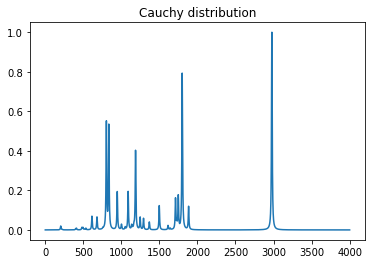

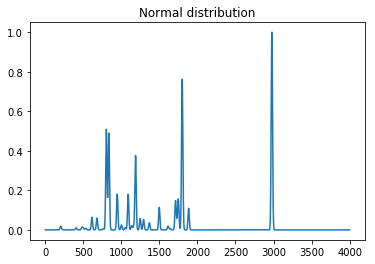

In [6]:
x = np.linspace(1,4000,4001)

y_cauchy_tot = np.zeros(len(x))
y_normal_tot = np.zeros(len(x))

# Set parameters; these will determine how clear the peaks are. I'm not sure how to set these!
scale = 5
sigma = 20/(2*(2*math.log(2))**0.5) # the '20' in the numerator represents 20 FWHM as I saw in a paper (can look it up if necessary)

# Is the molecule linear?
molecule_is_linear = False # <--- change this to specify whether the molecule is linear or not
if molecule_is_linear:
    no_of_non_vibrational = 5
else:
    no_of_non_vibrational = 6

for i in range(no_of_non_vibrational,len(eigenfrequencies)):
    # cauchy distribution
    y_cauchy = create_cauchy_distribution(x,eigenfrequencies[i],scale,intensities[i])
    y_cauchy_tot = y_cauchy_tot + y_cauchy
    # normal distribution
    y_normal = create_normal_distribution(x,eigenfrequencies[i],sigma,intensities[i])
    y_normal_tot = y_normal_tot + y_normal

# Normalize (optional)
y_cauchy_tot = y_cauchy_tot/np.amax(y_cauchy_tot)
y_normal_tot = y_normal_tot/np.amax(y_normal_tot)

plt.figure()
plt.plot(x,y_cauchy_tot)
plt.title("Cauchy distribution")

plt.figure()
plt.plot(x,y_normal_tot)
plt.title("Normal distribution")